# Haley Speed Week 4 Data Challenge

## The Problem

A clinical team at a research hospital is looking for the most cost-efficient means to determine whether a biopsy is benign or malignant based on histopathology. 

Since I do not have access to the cost per test, I have to assume that all tests cost the same. To make the pathology more cost effective, I will need to shorten the list of tests per sample.

The key is to find the minimum number of tests to accurately determine malignancy. 

This means I must be able to: 
- Reliably predict malignancy. 
- Reliably calculate the importance of each test

I want to avoid:
- False Positives because that's money wasted on unnecessary tests


## Dependencies

#### Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

#### Setup IO defaults

In [2]:
d_home = os.path.join('~',"Docs","insight","data_challenges")
d_data = os.path.join(d_home,'data')
d_raw = os.path.join(d_data,'raw')
d_clean = os.path.join(d_data, 'clean')

## Exploring the data

#### Getting the data

- Downloaded the data from Google Docs into OpenOffice odt format
- Opened in OpenOffice first and converted to csv in Numbers
- Removed the auto-index from the importing step
- Set the index to the sample ID

In [3]:
df = pd.read_csv(os.path.join(d_raw, 'week4_breast_cancer_raw.csv'))
df = df.drop('Index', axis = 1)
df = df.set_index('ID')
display(HTML(df.head().to_html()))

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
ID,,,,,,,,,,
1241035,7,8,3,7,4,5,7,8,2,4
1107684,6,10,5,5,4,10,6,10,1,4
691628,8,6,4,10,10,1,3,5,1,4
1226612,7,5,6,3,3,8,7,4,1,4
1142706,5,10,10,10,6,10,6,5,2,4


#### Remove duplicates

In [4]:
df = df.drop_duplicates()

#### Structure of the data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505 entries, 1241035 to 492268
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Clump Thickness              505 non-null    int64 
 1   Uniformity of Cell Size      500 non-null    object
 2   Uniformity of Cell Shape     500 non-null    object
 3   Marginal Adhesion            500 non-null    object
 4   Single Epithelial Cell Size  500 non-null    object
 5   Bare Nuclei                  500 non-null    object
 6   Bland Chromatin              500 non-null    object
 7   Normal Nucleoli              500 non-null    object
 8   Mitoses                      500 non-null    object
 9   Class                        500 non-null    object
dtypes: int64(1), object(9)
memory usage: 43.4+ KB


- ~16,000 samples, 12 features, so small dataset with good m/n ratio
- columns 0-9 should be numeric (int) but are currently objects

#### Convert the data columns to int, force str values to NA

In [6]:
num_cols = [c for c in df.columns.values if 'ID' not in c]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

#### Missing values with multivariate imputer

I used SimpleImputer with the median strategy rather than the mean since all but one of the features is skewed to the left.

In [7]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp = imp.fit(df[num_cols])
df[num_cols] = np.round(imp.transform(df[num_cols]))
display(HTML(df.head().to_html()))

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
ID,,,,,,,,,,
1241035,7.0,8.0,3.0,7.0,4.0,5.0,7.0,8.0,2.0,4.0
1107684,6.0,10.0,5.0,5.0,4.0,10.0,6.0,10.0,1.0,4.0
691628,8.0,6.0,4.0,10.0,10.0,1.0,3.0,5.0,1.0,4.0
1226612,7.0,5.0,6.0,3.0,3.0,8.0,7.0,4.0,1.0,4.0
1142706,5.0,10.0,10.0,10.0,6.0,10.0,6.0,5.0,2.0,4.0


#### Outliers

The instructions explicitly state that all entries are between 1-10, so we can safely assume the values in the 11-100 range are data entry errors easily corrected by dividing by 10.

In [8]:
for c in num_cols:
    df[c] = np.where (df[c] > 10, df[c]/10, df[c])
df.describe()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000
mean,5.461386,4.225743,4.308911,3.760396,3.786139,4.863366,4.130693,3.837624,2.134653,3.089109
std,2.876250,3.199785,3.053690,3.120595,2.368319,3.753721,2.567105,3.359033,2.463561,0.997010
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,3.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,5.000000,3.000000,4.000000,3.000000,3.000000,4.000000,3.000000,2.000000,1.000000,4.000000
75%,8.000000,7.000000,7.000000,6.000000,5.000000,10.000000,7.000000,7.000000,2.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


#### Remove classes other than 2 (benign) and 4 (malignant)

In [9]:
df = df[df.Class != 1][df.Class != 3][df.Class != 5]
print(np.unique(df.Class))

[2. 4.]


#### Descriptive statistics

In [10]:
df.describe()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000
mean,5.461386,4.225743,4.308911,3.760396,3.786139,4.863366,4.130693,3.837624,2.134653,3.089109
std,2.876250,3.199785,3.053690,3.120595,2.368319,3.753721,2.567105,3.359033,2.463561,0.997010
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,3.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,5.000000,3.000000,4.000000,3.000000,3.000000,4.000000,3.000000,2.000000,1.000000,4.000000
75%,8.000000,7.000000,7.000000,6.000000,5.000000,10.000000,7.000000,7.000000,2.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


#### Correlations

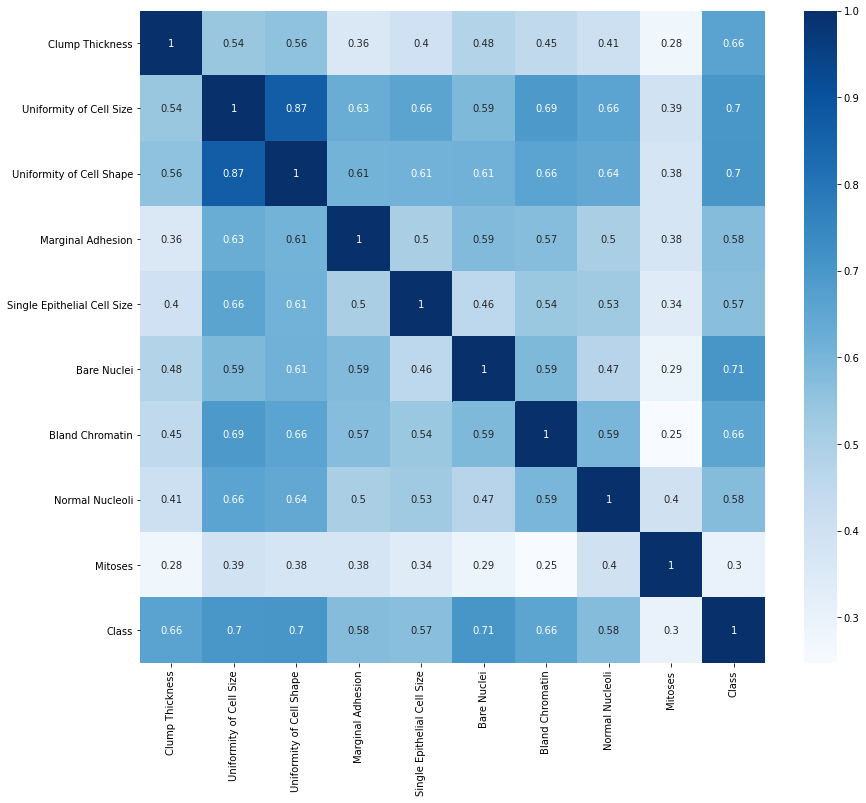

In [11]:
fig, ax = plt.subplots(figsize = (14,12))
sns.heatmap(df[num_cols].corr(), cmap = 'Blues', annot = True)

Major correlations were: 
- Uniformity of cell shape and size
- Uniformity of cell size and Normal Nuceoli
- Marginal adhesion and Single epithelial cell size 

#### EDA summary and plan

The classes aren't terribly skewed. Will use random forest because I can classify and make malignant/benign prediction and get important features with one model. If weighting compensates for the slight Class imbalance, then I'll add weighting.

## Make Test and Training Sets

#### Random sampling method
Randomly shuffle my original dataset and split 75/25% training/testing.

In [12]:
from sklearn.model_selection import ShuffleSplit

train_cols = [c for c in num_cols if 'Class' not in c]
split = ShuffleSplit(n_splits = 10, test_size = 0.25, random_state = 17)

for train_index, test_index in split.split(df[train_cols], df.Class):
    shuff_train = df.iloc[train_index][:]
    shuff_test = df.iloc[test_index][:]

In [13]:
y_train = shuff_train.Class
X_train = shuff_train.drop('Class', axis = 1)
y_test = shuff_test.Class
X_test = shuff_test.drop('Class', axis = 1)

#### Scaling
Preprocessing step for reliable execution in scikit-learn modules. Sets the mean and ssd of the dataset to 0.

In [14]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
print('Scaler mean: ') 
print(scaler.mean_)

Scaler mean: 
[5.54761905 4.24074074 4.35185185 3.78835979 3.79365079 4.93915344
 4.08730159 3.80687831 2.17989418]


In [15]:
print("Scaler scale: ")
print(scaler.scale_)

Scaler scale: 
[2.9094095  3.23550598 3.07928894 3.10020855 2.40914525 3.7654797
 2.57281219 3.40047542 2.53429764]


## Run machine learning model

#### Check shapes of X_test and X_train
Ensures no errors in preprocessing the test and training sets and that the number of features is the same for both.

In [16]:
print(X_train.shape, X_test.shape)

(378, 9) (127, 9)


#### Define the model
Model is a random forest classifier slightly weighted to compensate for the small imbalance in representation between benign and malignant samples.

In [17]:
from sklearn.ensemble import RandomForestClassifier
class_weight = dict({0:1.5})
forest = RandomForestClassifier(n_jobs=-1, 
            bootstrap=True,
            n_estimators=100,
            oob_score=True,random_state=17)

#### Fit the model

In [18]:
forest_fit = forest.fit(np.array(X_train), y_train)

#### Make predictions

In [19]:
predictions = forest_fit.predict(X_test)
df_pred = pd.DataFrame(X_test)
df_pred['prediction'] = predictions
df_pred['actual'] = y_test
display(HTML(df_pred[:25].to_html()))

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,prediction,actual
ID,,,,,,,,,,,
432809,3.0,1.0,3.0,1.0,2.0,4.0,2.0,1.0,1.0,2.0,2.0
1171795,1.0,3.0,1.0,2.0,2.0,2.0,5.0,3.0,2.0,2.0,2.0
1268804,3.0,1.0,1.0,1.0,2.0,5.0,1.0,1.0,1.0,2.0,2.0
476903,10.0,5.0,7.0,3.0,3.0,7.0,3.0,3.0,8.0,4.0,4.0
1125035,9.0,4.0,5.0,10.0,6.0,10.0,4.0,8.0,1.0,4.0,4.0
822829,7.0,6.0,4.0,8.0,10.0,10.0,9.0,5.0,3.0,4.0,4.0
1002504,3.0,2.0,2.0,2.0,2.0,1.0,3.0,2.0,1.0,2.0,2.0
1067444,2.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0
8325670,4.0,2.0,3.0,5.0,3.0,8.0,7.0,6.0,10.0,4.0,4.0


## Validate the results

#### Get Metrics

In [20]:
from sklearn import metrics
mets = metrics.classification_report(y_test, predictions, digits = 3)
print(mets)

              precision    recall  f1-score   support

         2.0      0.981     0.914     0.946        58
         4.0      0.932     0.986     0.958        69

    accuracy                          0.953       127
   macro avg      0.956     0.950     0.952       127
weighted avg      0.954     0.953     0.953       127



I'm most interested in precision and recall for the malginant class out of this metrics table. Recall because I want to keep patient health a priority. If I'm classifying malignant tumors as benign to cut costs, I'm causing harm to the patient and delaying treatment. On the economic side, I'm paying close attention to the precision because I don't want to waste resources performing tests on benign tumors misclassified as malignant. However, given the tradeoff between precision and recall, I will maximize recall. This is a research hospital and must first do no harm, so misclassifying a benign tumor as malignant is more acceptable than misclassifying a malignant tumor as benign.

#### Get confusion matrix

In [21]:
cnf = metrics.confusion_matrix (y_test, predictions)
print(cnf)

[[53  5]
 [ 1 68]]


#### Plot confusion matrix

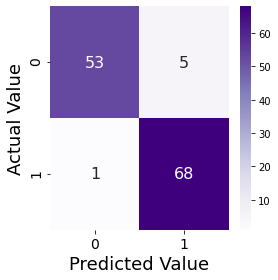

In [22]:
fig, ax = plt.subplots(figsize = (4,4))
sns.heatmap(pd.DataFrame(cnf), annot = True, cmap = 'Purples', 
            fmt = 'g', annot_kws={"size":16})
ax.set_xlabel ("Predicted Value", fontsize = 18)
ax.set_ylabel ("Actual Value", fontsize = 18)
ax.tick_params (labelsize = 14)
plt.tight_layout()

#### Get RF feature importances

In [23]:
importances = forest_fit.feature_importances_
dfi = pd.DataFrame(importances, index = X_train.columns, 
        columns = ['Importance']).sort_values('Importance', 
        ascending = False)
dfi

,Importance
Uniformity of Cell Size,0.257595
Uniformity of Cell Shape,0.218453
Bare Nuclei,0.158959
Single Epithelial Cell Size,0.097464
Clump Thickness,0.084500
Marginal Adhesion,0.069221
Bland Chromatin,0.055999
Normal Nucleoli,0.045623
Mitoses,0.012186


#### Plot histograms for top 5 features for each class

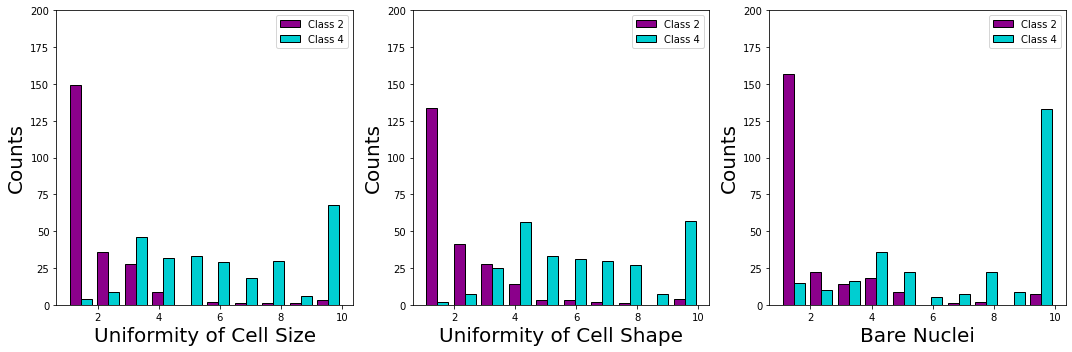

In [24]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
ax[0].hist([df['Uniformity of Cell Size'][df.Class == 2],
         df['Uniformity of Cell Size'][df.Class == 4]], 
        label = ['Class 2', 'Class 4'], 
        color = ['darkmagenta', 'darkturquoise'], 
        edgecolor = 'black')
ax[1].hist([df['Uniformity of Cell Shape'][df.Class == 2],
         df['Uniformity of Cell Shape'][df.Class == 4]], 
        label = ['Class 2', 'Class 4'], 
        color = ['darkmagenta', 'darkturquoise'], 
        edgecolor = 'black')
ax[2].hist([df['Bare Nuclei'][df.Class == 2],
         df['Bare Nuclei'][df.Class == 4]], 
        label = ['Class 2', 'Class 4'], 
        color = ['darkmagenta', 'darkturquoise'], 
        edgecolor = 'black')


ax[0].set_xlabel('Uniformity of Cell Size', fontsize = 20)
ax[0].set_ylabel('Counts', fontsize = 20)
ax[0].set_ylim (0,200)
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels)

ax[1].set_xlabel('Uniformity of Cell Shape', fontsize = 20)
ax[1].set_ylabel('Counts', fontsize = 20)
ax[1].set_ylim(0, 200)
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles, labels)

ax[2].set_xlabel('Bare Nuclei', fontsize = 20)
ax[2].set_ylabel('Counts', fontsize = 20)
ax[2].set_ylim(0,200)
handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles, labels)
plt.tight_layout()

## Summary

The random forest did an excellent job of determining which biopsies were malignant with a precision of 98.1%, meaning very few false positives and no wasted resources on misclassified (benign) biopsies. Likewise, with patient health a priority, there were even fewer false negatives, indicated by a recall of 98.6%. 

I would recommend a histology panel for uniformity of cell size, uniformity of cell shape, and bare nuclei as a primary screen for malignant tissue. Cell size and shape were highly correlated but not bare nuclei. All three had distinct distributions in benign and malignant cells and scored the highest among feature importances, 25.7%, 21.8%, and 15.9%, respectively.
